In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist as mnist 
import jax
import jax.numpy as jnp
from jax import grad

In [3]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x = x_train[0]
y_true = x.copy()


In [6]:
# Add salt-and-pepper noise
num_corrupted_pixels = 100
for _ in range(num_corrupted_pixels):
    i, j = np.random.randint(0, x.shape[0]), np.random.randint(0, x.shape[1])
    x[i, j] = np.random.choice([0, 255])

In [7]:
# Normalize images
y_true = y_true.astype(np.float32) / 255.0
x = x.astype(np.float32) / 255.0

In [8]:
# Define convolution function using JAX
def convolution_2d(x, kernel):
    input_height, input_width = x.shape
    kernel_height, kernel_width = kernel.shape
    pad_height, pad_width = kernel_height // 2, kernel_width // 2

    # Pad the input array by adding extra pixel
    padded_x = jnp.pad(x, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Initialize the output matrix
    output_data = jnp.zeros_like(x)

    # Perform the convolution operation
    for i in range(input_height):
        for j in range(input_width):
            # Extract the region of interest
            region = padded_x[i:i + kernel_height, j:j + kernel_width]
            # Perform element-wise multiplication and summation
            output_data = output_data.at[i, j].set(jnp.sum(region * kernel))
            # Equivalent to : output_data[i, j] = jnp.sum(region * kernel)

    return output_data


In [9]:
# Define loss function
def loss_fn(kernel, x, y_true):
    y_pred = convolution_2d(x, kernel)
    return jnp.mean((y_pred - y_true) ** 2)  # Mean squared error


In [10]:
# Initialize kernel
kernel = jnp.array([[0.01, 0.0, 0.0],
                    [-1.0, 0.0, 1.0],
                    [0.0, 0.0, 0.0]])  # Random kernel for horizontal edge detection


In [11]:
# Gradient of the loss function w.r.t. the kernel
loss_grad = grad(loss_fn)

# Training loop
learning_rate = 0.01
num_iterations = 10

In [12]:
losses = []
for i in range(num_iterations):
    gradients = loss_grad(kernel, x, y_true)
    kernel -= learning_rate * gradients  # Update kernel with gradient descent

    # Compute and store the loss
    current_loss = loss_fn(kernel, x, y_true)
    losses.append(current_loss)

    # Print loss every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {current_loss:.4f}")


Iteration 0, Loss: 0.2612


In [13]:
# Visualize results
plt.figure(figsize=(8, 6))


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Text(0, 0.5, 'Loss')

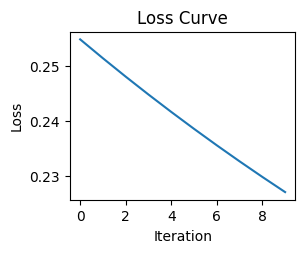

In [13]:
# Plot loss over iterations
plt.subplot(2, 2, 1)
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")

(-0.5, 27.5, 27.5, -0.5)

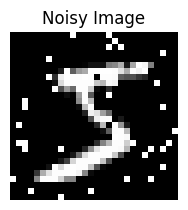

In [14]:
# Display original noisy image
plt.subplot(2, 2, 2)
plt.imshow(x, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

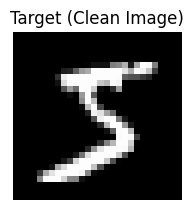

In [15]:
# Display target clean image
plt.subplot(2, 2, 3)
plt.imshow(y_true, cmap='gray')
plt.title("Target (Clean Image)")
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

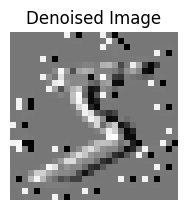

In [16]:
# Display denoised image
y_denoised = convolution_2d(x, kernel)
plt.subplot(2, 2, 4)
plt.imshow(y_denoised, cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

In [17]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### Parallel training

In [ ]:
from mpi4py import MPI

In [ ]:
comm = MPI.COMM_WORLD
rank = com.Get_rank()
size = comm.Get_size()

In [ ]:
if rank == 0:
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x=x_train[0]
    y_true = x.copy()

    # Add salt-and-pepper noise
    num_corrupted_pixels = 100
    for _ in range(num_corrupted_pixels):
        i, j = np.random.randint(0, x.shape[0]), np.random.randint(0, x.shape[1])
        x[i, j] = np.random.choice([0, 255])

    # Normalize images
    y_true = y_true.astype(np.float32) / 255.0
    x = x.astype(np.float32) / 255.0

else:
    x = None 
    y_true = None 
    

In [ ]:
x = comm.bcast(x, root=0)
y_true = comm.bcast(y_true, root=0)

In [ ]:
# Initialize kernel
kernel = jnp.array([[0.01, 0.0, 0.0],
                    [-1.0, 0.0, 1.0],
                    [0.0, 0.0, 0.0]])  # Random kernel for horizontal edge detection


In [ ]:
# Gradient of the loss function w.r.t. the kernel
loss_grad = grad(loss_fn)

# Training loop
learning_rate = 0.01
num_iterations = 10

In [ ]:
# Divide iterations among processes
iterations_per_process = num_iterations // size
start_iteration = rank * iterations_per_process
end_iteration = start_iteration + iterations_per_process

In [ ]:
local_losses = []
for i in range(start_iteration, end_iteration):
    gradients = loss_grad(kernel, x, y_true)
    kernel -= learning_rate * gradients  # Update kernel with gradient descent

    # Compute and store the loss
    current_loss = loss_fn(kernel, x, y_true)
    local_losses.append(current_loss)

    # Print loss for each process
    if i % 10 == 0:
        print(f"Process {rank}, Iteration {i}, Loss: {current_loss:.4f}")


In [ ]:
# Gather losses from all processes
all_losses = comm.gather(local_losses, root=0)
